# Named Entity Recognition task using RoBERTa
## test 1

In [ ]:
!pip install transformers datasets seqeval scikit-learn -q
!pip install evaluate -q

import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer
from datasets import Dataset, DatasetDict
from evaluate import load
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load CoNLL file
def load_conll_file(filepath):
    """
    Load sentences and tags from a CoNLL formatted file.

    Args:
        filepath (str): Path to the CoNLL file.

    Returns:
        tuple: A tuple containing two lists:
               - sentences: List of tokenized sentences.
               - tags: List of tag sequences for each sentence.
    """
    sentences = []
    tags = []
    with open(filepath, "r") as file:
        sentence = []
        tag_sequence = []
        for line in file:
            line = line.strip()
            if not line:  # End of a sentence
                if sentence:
                    sentences.append(sentence)
                    tags.append(tag_sequence)
                sentence = []
                tag_sequence = []
            else:
                token, tag = line.split()[:2]  # Extract token and tag
                sentence.append(token)
                tag_sequence.append(tag)
        if sentence:  # Append the last sentence if present
            sentences.append(sentence)
            tags.append(tag_sequence)
    return sentences, tags

# Load training and testing data
train_sentences, train_tags = load_conll_file("/content/re3d-train.conll")
test_sentences, test_tags = load_conll_file("/content/re3d-test.conll")

# Prepare the dataset
unique_tags = sorted(set(tag for tags in train_tags for tag in tags))
tag2id = {tag: i for i, tag in enumerate(unique_tags)}
id2tag = {i: tag for tag, i in tag2id.items()}

# Encode tags as integers
def encode_tags(tags, tag2id):
    """
    Convert tag sequences into integer-encoded format using a mapping.

    Args:
        tags (list): List of tag sequences.
        tag2id (dict): Dictionary mapping tags to integers.

    Returns:
        list: List of integer-encoded tag sequences.
    """
    return [[tag2id[tag] for tag in sentence_tags] for sentence_tags in tags]

train_tag_ids = encode_tags(train_tags, tag2id)
test_tag_ids = encode_tags(test_tags, tag2id)

# Transform data into Dataset format
train_data = [{"tokens": tokens, "tags": tags} for tokens, tags in zip(train_sentences, train_tag_ids)]
test_data = [{"tokens": tokens, "tags": tags} for tokens, tags in zip(test_sentences, test_tag_ids)]

dataset = DatasetDict({
    "train": Dataset.from_list(train_data),
    "test": Dataset.from_list(test_data),
})

# Tokenization and alignment of labels
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)

def tokenize_and_align_labels(examples):
    """
    Tokenize sentences and align the corresponding labels with the tokens.

    Args:
        examples (dict): Dictionary containing sentences and tags.

    Returns:
        dict: Dictionary with tokenized inputs and aligned labels.
    """
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True, padding="max_length", max_length=128
    )
    labels = []
    for i, label in enumerate(examples["tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        label_ids = []
        previous_word_id = None
        for word_id in word_ids:
            if word_id is None:
                label_ids.append(-100)  # Ignore tokens that do not correspond to words
            elif word_id != previous_word_id:  # Assign the label to the first subword
                label_ids.append(label[word_id])
            else:
                label_ids.append(-100)  # Ignore subsequent subwords
            previous_word_id = word_id
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=True)

# Define the model and training parameters
model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=len(unique_tags))
model.config.id2label = id2tag
model.config.label2id = tag2id

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",  # Evaluate at the end of each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    save_strategy="epoch",  # Save the model at the end of each epoch
)

# Define evaluation function
metric = load("seqeval")

def compute_metrics(eval_pred):
    """
    Compute evaluation metrics (precision, recall, F1, and accuracy).

    Args:
        eval_pred (tuple): A tuple containing predictions and true labels.

    Returns:
        dict: Dictionary of computed metrics.
    """
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=2)

    # Remove padding
    true_labels = [[id2tag[label] for label in sentence if label != -100] for sentence in labels]
    true_predictions = [[id2tag[pred] for pred, label in zip(sentence, labels[i]) if label != -100]
                        for i, sentence in enumerate(predictions)]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Final evaluation
results = trainer.evaluate()
print(results)


Map:   0%|          | 0/765 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


<ipython-input-4-0ad8a82a9f3d>:139: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.080800,0.754752,0.423333,0.375740,0.398119,0.797261
2,0.522300,0.484678,0.569975,0.662722,0.612859,0.858882
3,0.363200,0.402527,0.612091,0.718935,0.661224,0.884176
4,0.334100,0.381574,0.620076,0.721893,0.667122,0.887219
5,0.283000,0.381802,0.605392,0.730769,0.662198,0.886078


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-sco

{'eval_loss': 0.38157424330711365, 'eval_precision': 0.6200762388818297, 'eval_recall': 0.7218934911242604, 'eval_f1': 0.6671223513328777, 'eval_accuracy': 0.8872194750855839, 'eval_runtime': 1.4799, 'eval_samples_per_second': 135.143, 'eval_steps_per_second': 8.784, 'epoch': 5.0}


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
                     precision    recall  f1-score   support

B-DocumentReference       0.00      0.00      0.00         8
         B-Location       0.79      0.79      0.79       155
 B-MilitaryPlatform       0.00      0.00      0.00        16
            B-Money       0.00      0.00      0.00         4
      B-Nationality       0.00      0.00      0.00        10
     B-Organisation       0.74      0.80      0.77       284
           B-Person       0.82      0.96      0.88       106
         B-Quantity       0.68      0.83      0.75        30
         B-Temporal       0.69      0.76      0.72        46
           B-Weapon       0.33      0.06      0.10        17
I-DocumentReference       0.60      0.75      0.67        20
         I-Location       0.71      0.89      0.79       191
 I-MilitaryPlatform       0.00      0.00      0.00        26
            I-Money       1.00      0.11      0.20         9
      I-Nationality       0.00      0.00      0.00         2


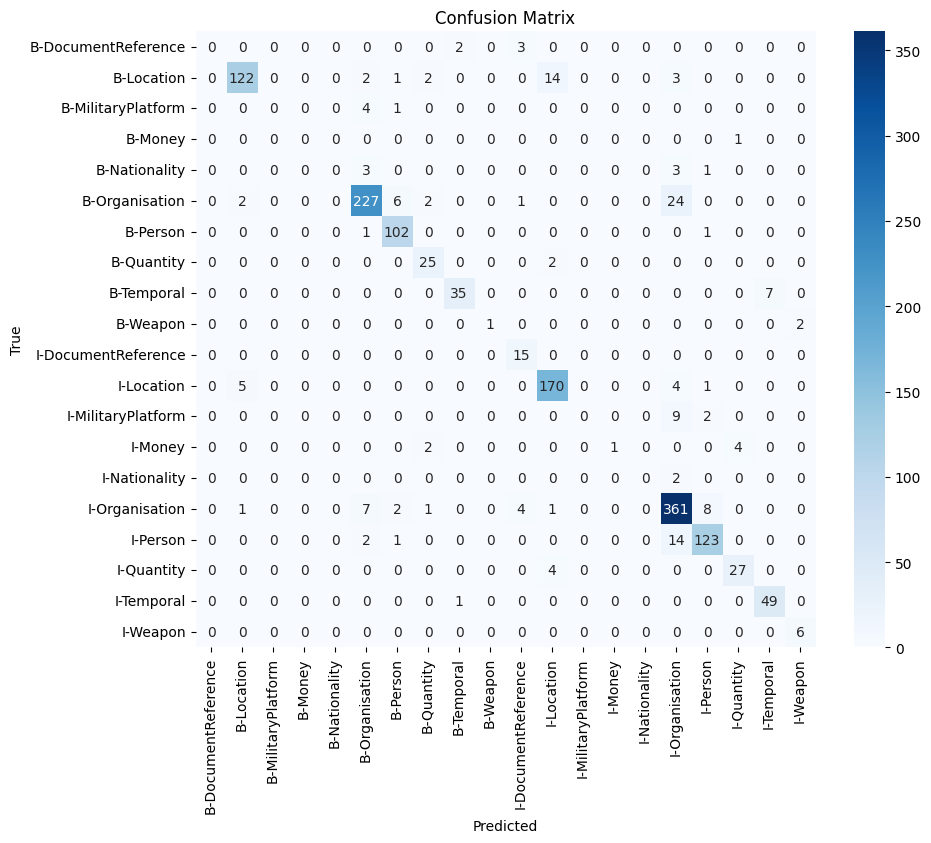

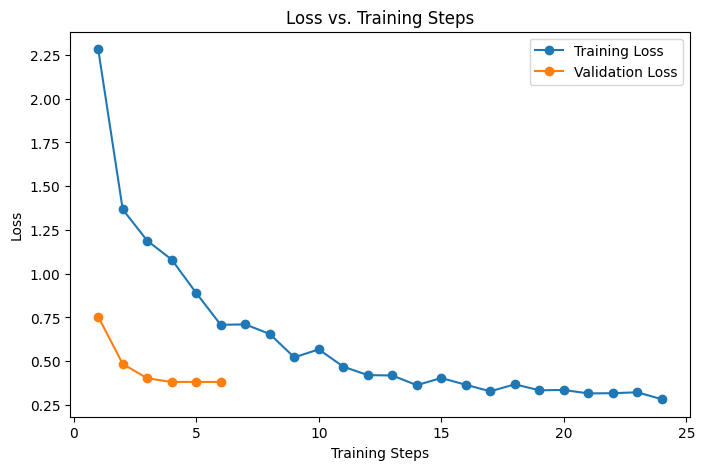

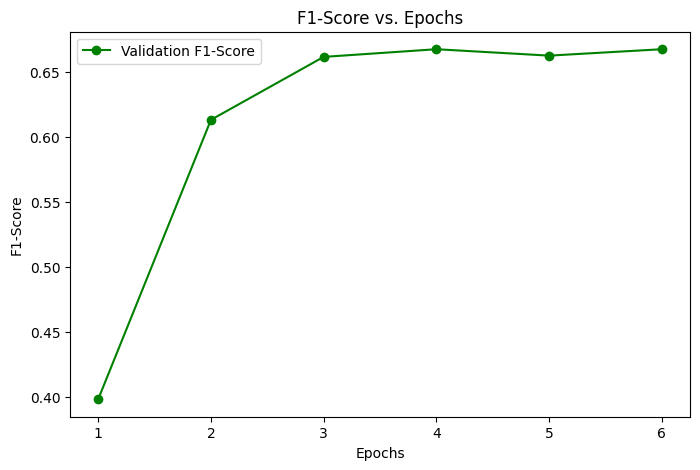

In [ ]:
# Function to calculate and display the classification report
def generate_classification_report(trainer, dataset, id2tag):
    """
    Generate and print a classification report for token classification.

    Args:
        trainer (Trainer): The Trainer instance used for training and evaluation.
        dataset (Dataset): The dataset to evaluate.
        id2tag (dict): A mapping from label IDs to their corresponding tags.

    Returns:
        tuple: A tuple containing:
               - y_true: Flattened list of true labels.
               - y_pred: Flattened list of predicted labels.
    """
    predictions, labels, _ = trainer.predict(dataset)
    predictions = np.argmax(predictions, axis=2)

    # Remove padding (-100) and reconstruct original tags
    true_labels = [
        [id2tag[label] for label in sentence if label != -100] for sentence in labels
    ]
    true_predictions = [
        [id2tag[pred] for pred, label in zip(sentence, labels[i]) if label != -100]
        for i, sentence in enumerate(predictions)
    ]

    # Flatten lists for report generation
    y_true = [label for sentence in true_labels for label in sentence]
    y_pred = [pred for sentence in true_predictions for pred in sentence]

    # Generate classification report
    report = classification_report(y_true, y_pred, labels=list(id2tag.values()), zero_division=0)
    print("Classification Report:")
    print(report)
    return y_true, y_pred

# Function to generate and visualize the confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    """
    Generate and display a confusion matrix heatmap.

    Args:
        y_true (list): Flattened list of true labels.
        y_pred (list): Flattened list of predicted labels.
        classes (list): List of class names to display on the matrix.
    """
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# Function to plot training metrics such as loss and F1-score
def plot_training_metrics(log_history):
    """
    Plot training and validation loss, as well as validation F1-score, over training steps.

    Args:
        log_history (list): Log history from the Trainer, containing loss and evaluation metrics.
    """
    # Calculate the total number of training steps
    num_training_steps = sum(1 for entry in log_history if "loss" in entry)

    # Adjust epochs to reflect the number of logged training losses
    epochs = range(1, num_training_steps + 1)

    # Extract training loss, evaluation loss, and F1-score from the log
    train_loss = [entry["loss"] for entry in log_history if "loss" in entry]
    eval_loss = [entry["eval_loss"] for entry in log_history if "eval_loss" in entry]
    eval_f1 = [entry["eval_f1"] for entry in log_history if "eval_f1" in entry]

    # Plot training and validation loss
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_loss, label="Training Loss", marker="o")

    # Plot validation metrics against actual epoch numbers
    eval_epochs = range(1, len(eval_loss) + 1)  # Epochs for evaluation metrics
    plt.plot(eval_epochs, eval_loss, label="Validation Loss", marker="o")

    plt.xlabel("Training Steps")  # x-axis label for training steps
    plt.ylabel("Loss")
    plt.title("Loss vs. Training Steps")
    plt.legend()
    plt.show()

    # Plot F1-score over epochs
    plt.figure(figsize=(8, 5))
    plt.plot(eval_epochs, eval_f1, label="Validation F1-Score", marker="o", color="green")
    plt.xlabel("Epochs")
    plt.ylabel("F1-Score")
    plt.title("F1-Score vs. Epochs")
    plt.legend()
    plt.show()

# Generate classification report and confusion matrix
y_true, y_pred = generate_classification_report(trainer, tokenized_datasets["test"], id2tag)

# List of classes excluding "O" for clarity
classes = [tag for tag in unique_tags if tag != "O"]

plot_confusion_matrix(y_true, y_pred, classes)

# Visualize training metrics
plot_training_metrics(trainer.state.log_history)
